# Step 1: 载入并预处理实验 JSON 数据
使用 `pandas` 和 `json` 库读取实验日志。将嵌套的 `result` 和 `config` 字典平铺展开为 DataFrame，以便后续进行数据透视操作。

In [16]:
# 检查依赖并安装 (如果需要)
# !pip install pandas matplotlib numpy

In [17]:
import pandas as pd
import json
import glob
import os

json_files = ["exp_res.json"]

# 寻找最新的 experiment_summary_*.json 文件
json_files = (
    glob.glob("experiment_summary_*.json")
    if json_files is None
    else json_files
)
if not json_files:
    print("找不到任何实验总结 JSON 文件")
    # 如果没有自动生成的，尝试手动指定一个
    filename = "experiment_summary_20260201_121422.json"
else:
    # 获取最新的文件
    filename = max(json_files, key=os.path.getmtime)

print(f"正在读取文件: {filename}")

with open(filename, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 将嵌套的 JSON 数据平铺展开
df = pd.json_normalize(data)
df.head()

正在读取文件: exp_res.json


,exp_name,log_file,status,result.little_forward_times,result.draft_forward_times,result.target_forward_times,result.generated_tokens,result.little_generated_tokens,result.draft_generated_tokens,result.little_accepted_tokens,...,config.use_rl_adapter,config.disable_rl_update,config.draft_model,config.target_model,config.little_model,config.use_early_stopping,config.small_draft_acc_head_path,config.draft_target_acc_head_path,config.main_rl_path,config.little_rl_path
0,dist_split_spec/mt_bench/dist_split_spec_8shot...,exp_logs/dist_split_spec_mt_bench_dist_split_s...,success,0,27833,7090,20480,0,27833,0,...,True,True,llama-68m,llama-2-13b,llama-68m,False,,src/SpecDec_pp/checkpoints/llama-13b/exp-weigh...,checkpoints/llama/rl_adapter_main.pth,checkpoints/llama/rl_adapter_little.pth
1,dist_spec/mt_bench/dist_spec_8shot_20260202_01...,exp_logs/dist_spec_mt_bench_dist_spec_8shot_20...,success,0,27833,7090,20480,0,27833,0,...,True,True,llama-68m,llama-2-13b,llama-68m,False,,src/SpecDec_pp/checkpoints/llama-13b/exp-weigh...,checkpoints/llama/rl_adapter_main.pth,checkpoints/llama/rl_adapter_little.pth
2,uncertainty_decoding/mt_bench/uncertainty_deco...,exp_logs/uncertainty_decoding_mt_bench_uncerta...,success,0,10358,546,20480,0,10358,0,...,True,True,llama-68m,llama-2-13b,llama-68m,False,,src/SpecDec_pp/checkpoints/llama-13b/exp-weigh...,checkpoints/llama/rl_adapter_main.pth,checkpoints/llama/rl_adapter_little.pth
3,dist_split_spec/humaneval/dist_split_spec_8sho...,exp_logs/dist_split_spec_humaneval_dist_split_...,success,0,18376,4696,10240,0,18376,0,...,True,True,llama-68m,llama-2-13b,llama-68m,False,,src/SpecDec_pp/checkpoints/llama-13b/exp-weigh...,checkpoints/llama/rl_adapter_main.pth,checkpoints/llama/rl_adapter_little.pth
4,large/mt_bench/large_8shot_20260202_010955,exp_logs/large_mt_bench_large_8shot_20260202_0...,success,0,0,20480,20480,0,0,0,...,True,True,llama-68m,llama-2-13b,llama-68m,False,,src/SpecDec_pp/checkpoints/llama-13b/exp-weigh...,checkpoints/llama/rl_adapter_main.pth,checkpoints/llama/rl_adapter_little.pth


# Step 2: 筛选 Adaptive Tridecoding 模式数据
根据 `config.eval_mode` 或 `result.eval_mode` 字段筛选出 Adaptive Tridecoding 模式的记录。根据提供的 outline 要求，我们主要关注 `adaptive_tridecoding` 模式。如果数据中使用 `large` 表示该模式，也会一并考虑。

In [18]:
# 筛选 adaptive_tridecoding
# 注意：根据需求，我们只针对 "adaptive_tridecoding" 模式。
# 如果您的数据中该模式被标记为 "large"，请将 "large" 加入 target_target_modes。
target_modes = ['adaptive_tridecoding']

# 优先在 result 或 config 中寻找 eval_mode
mode_col = None
for col in ['result.eval_mode', 'config.eval_mode']:
    if col in df.columns:
        mode_col = col
        break

if mode_col:
    filtered_df = df[df[mode_col].isin(target_modes)].copy()
else:
    # 模糊匹配
    mode_cols = [c for c in df.columns if 'eval_mode' in c]
    if mode_cols:
        filtered_df = df[df[mode_cols[0]].isin(target_modes)].copy()
    else:
        filtered_df = df.copy()

print(f"筛选出的 {target_modes} 记录数: {len(filtered_df)}")

筛选出的 ['adaptive_tridecoding'] 记录数: 9


# Step 3: 解析时间组成指标并进行数据格式转换
提取 `computation_time`, `communication_time`, `queuing_time` 以及其他开销时间。计算各分量占 `wall_time` 的比例。同时提取数据集名称和模型名称。

In [19]:
import numpy as np

# 定义我们感兴趣的时间列
time_cols = {
    'result.computation_time': 'Computation',
    'result.communication_time': 'Communication',
    'result.queuing_time': 'Queuing',
    'result.arp_overhead_time': 'ARP Overhead',
    'result.dra_overhead_time': 'DRA Overhead'
}

# 确保列存在，不存在则补0
for col in time_cols.keys():
    if col not in filtered_df.columns:
        filtered_df[col] = 0.0

# 提取并重命名数据集
def get_dataset_name(x):
    if pd.isna(x): return 'unknown'
    name = x.split('/')[-1].replace('eval_', '').replace('.py', '')
    # 重命名映射
    mapping = {
        'mt_bench': 'MT-Bench',
        'mt_bench_eval': 'MT-Bench',
        'mt_bench_noeval': 'MT-Bench',
        'mt_bench_nooeval': 'MT-Bench',
        'gsm8k': 'GSM8K',
        'humaneval': 'HumanEval'
    }
    return mapping.get(name, name)

filtered_df['dataset'] = filtered_df['config.eval_dataset'].apply(get_dataset_name)

# 统一模型名称 (只保留最后一部分)
def simplify_model_name(name):
    if isinstance(name, str) and "/" in name:
        return name.split("/")[-1]
    return name

filtered_df['model'] = filtered_df['result.target_model'].apply(simplify_model_name).fillna('unknown')

# 计算各组分的占比
filtered_df['total_measured_time'] = filtered_df[list(time_cols.keys())].sum(axis=1)

for col, label in time_cols.items():
    # 同时保留绝对值列和占比列
    filtered_df[f'{label}_abs'] = filtered_df[col]
    filtered_df[f'{label}_pct'] = filtered_df[col] / filtered_df['total_measured_time'].replace(0, 1) * 100

# 准备列名单
abs_cols = [f'{label}_abs' for label in time_cols.values()]
pct_cols = [f'{label}_pct' for label in time_cols.values()]

final_df = filtered_df[['model', 'dataset', 'result.wall_time', 'total_measured_time'] + abs_cols + pct_cols].copy()
final_df.head()

,model,dataset,result.wall_time,total_measured_time,Computation_abs,Communication_abs,Queuing_abs,ARP Overhead_abs,DRA Overhead_abs,Computation_pct,Communication_pct,Queuing_pct,ARP Overhead_pct,DRA Overhead_pct
6,Llama-2-13b-hf,MT-Bench,824.552631,840.873117,523.580239,113.872391,187.10,7.346138,8.974349,62.266260,13.542161,22.250682,0.873632,1.067265
8,Llama-2-13b-hf,HumanEval,366.089571,372.348175,238.025511,48.514060,79.55,2.499655,3.758950,63.925521,13.029219,21.364412,0.671322,1.009525
14,Llama-2-13b-hf,GSM8K,471.670383,479.526236,272.772109,75.448275,123.45,2.892224,4.963629,56.883667,15.733920,25.744160,0.603142,1.035111
23,vicuna-13b-v1.5,MT-Bench,1620.003805,1640.279300,1026.295566,224.308239,369.40,7.993482,12.282013,62.568342,13.675003,22.520555,0.487324,0.748776
26,vicuna-13b-v1.5,HumanEval,814.292431,824.501957,538.174221,104.468210,171.65,4.292995,5.916530,65.272643,12.670462,20.818629,0.520677,0.717588


# Step 4: 按模型与数据集分组生成堆积柱状图可视化
使用 `matplotlib` 绘制堆积柱状图。横轴为数据集，通过颜色区分不同的时间构成。为每个模型生成一个独立的图表。

### Wall Time Composition Breakdown by Model and Dataset

,model,dataset,result.wall_time,Computation_abs,Communication_abs,Queuing_abs,ARP Overhead_abs,DRA Overhead_abs,Computation_pct,Communication_pct,Queuing_pct,ARP Overhead_pct,DRA Overhead_pct
0,Llama-2-13b-hf,GSM8K,471.67,272.77,75.45,123.45,2.89,4.96,56.88,15.73,25.74,0.60,1.04
1,Llama-2-13b-hf,HumanEval,366.09,238.03,48.51,79.55,2.50,3.76,63.93,13.03,21.36,0.67,1.01
2,Llama-2-13b-hf,MT-Bench,824.55,523.58,113.87,187.10,7.35,8.97,62.27,13.54,22.25,0.87,1.07
3,Qwen3-14B,GSM8K,685.63,493.88,72.80,118.95,5.53,4.53,70.99,10.46,17.10,0.79,0.65
4,Qwen3-14B,HumanEval,694.71,479.28,81.63,133.80,3.33,4.67,68.20,11.62,19.04,0.47,0.66
5,Qwen3-14B,MT-Bench,1522.96,1042.52,181.79,298.65,8.44,11.79,67.56,11.78,19.35,0.55,0.76
6,vicuna-13b-v1.5,GSM8K,1060.18,753.46,116.32,190.40,6.01,6.86,70.22,10.84,17.74,0.56,0.64
7,vicuna-13b-v1.5,HumanEval,814.29,538.17,104.47,171.65,4.29,5.92,65.27,12.67,20.82,0.52,0.72
8,vicuna-13b-v1.5,MT-Bench,1620.00,1026.30,224.31,369.40,7.99,12.28,62.57,13.68,22.52,0.49,0.75


图表已平稳保存至: walltime_composition_grid.pdf


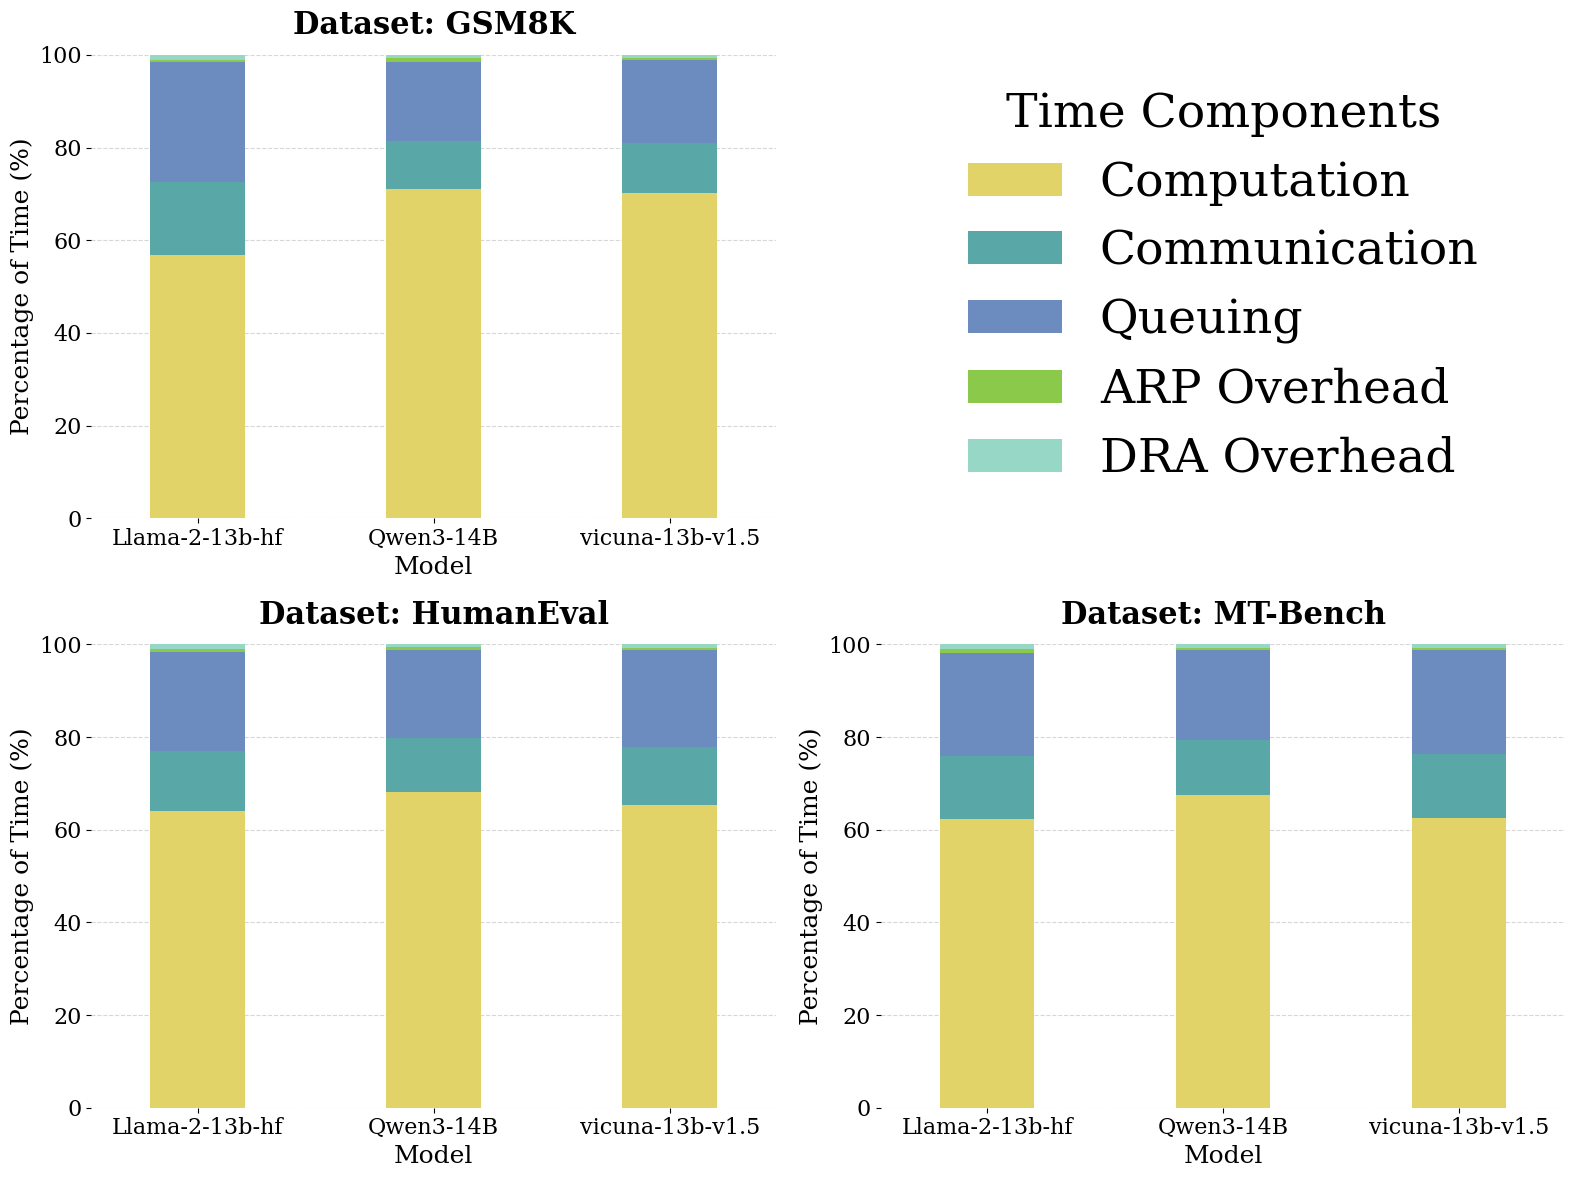

In [20]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# 1. 聚合数据: 按模型和数据集聚合，不进行跨数据集合并
agg_df = final_df.groupby(['model', 'dataset']).mean(numeric_only=True).reset_index()

# 2. 输出原始数据表格 (包含数据集维度)
display(Markdown("### Wall Time Composition Breakdown by Model and Dataset"))
display_cols = ['model', 'dataset', 'result.wall_time'] + abs_cols + pct_cols
table_df = agg_df[display_cols].round(2)
display(table_df)

# 3. 绘制汇总图表 (2x2 布局: 柱状图 图例 / 柱状图 柱状图)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

datasets = agg_df['dataset'].unique()
num_datasets = len(datasets)

# 设置配色方案
custom_colors = ['#E2D368', '#5AA7A7', '#6C8CBF', '#8AC94A', '#96D7C6']

# 绘制 2x2 布局
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 定义位置映射 (假设最多 3 个数据集)
# 第一行左: Dataset 1 | 第一行右: 图例
# 第二行左: Dataset 2 | 第二行右: Dataset 3
plot_positions = [(0, 0), (1, 0), (1, 1)]
legend_pos = (0, 1)

# 隐藏图例槽位的坐标轴
axes[legend_pos].axis('off')

for i, dataset in enumerate(datasets):
    if i >= len(plot_positions):
        break
        
    row, col = plot_positions[i]
    ax = axes[row, col]
    ds_data = agg_df[agg_df['dataset'] == dataset]
    
    # 绘图
    ds_data.set_index('model')[pct_cols].plot(
        kind='bar', 
        stacked=True, 
        ax=ax,
        color=custom_colors,
        legend=False,
        width=0.4
    )
    
    # 设置标题和标签
    ax.set_title(f'Dataset: {dataset}', fontsize=22, pad=15, fontweight='bold')
    ax.set_ylabel('Percentage of Time (%)', fontsize=18)
    ax.set_xlabel('Model', fontsize=18)
    ax.set_ylim(0, 100)
    
    # 优化刻度
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', rotation=0)
    
    # 取消边框
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # 添加横向网格
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

# 统一添加图例到 axes[0, 1]
handles, labels = axes[plot_positions[0]].get_legend_handles_labels()
clean_labels = [l.replace('_pct', '') for l in labels]

# 进一步增加图例字号
axes[legend_pos].legend(
    handles, 
    clean_labels, 
    title='Time Components', 
    loc='center', 
    frameon=False,
    fontsize=34, # 从 20 增大到 24
    title_fontsize=34 # 从 22 增大到 26
)

fig.tight_layout()

# 保存为 PDF 文件
plt.savefig('walltime_composition_grid.pdf', bbox_inches='tight', dpi=300)
print("图表已平稳保存至: walltime_composition_grid.pdf")

plt.show()
